In [ ]:
# !git clone https://github.com/AlirezaSM/template-matching.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/cplusx/QATM.git

Cloning into 'QATM'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 9.19 MiB | 8.86 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
!7z x drive/MyDrive/Dataset.7z -o.


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 5359681573 bytes (5112 MiB)

Extracting archive: drive/MyDrive/Dataset.7z
--
Path = drive/MyDrive/Dataset.7z
Type = 7z
Physical Size = 5359681573
Headers Size = 279463
Method = LZMA2:24
Solid = +
Blocks = 3

  0%      0% 1        0% 11 - Dataset/Sample0004_Image.png                                        0% 23 - Dataset/Sample0008_Image.png                                        0% 24 - Dataset/Sample0008_Template.png                                           0% 35 -

# Using QATM for template matching

In [ ]:
from __future__ import print_function, division

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, sys

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Concatenate
from keras import Model
import keras.backend as K
from keras.applications.vgg16 import preprocess_input
import progressbar

In [ ]:
print(keras.__version__, tf.__version__)

2.9.0 2.9.2


In [ ]:
from QATM.models import QATM, MyNormLayer
from QATM.utils import compute_score, all_sample_iou, plot_success_curve

In [ ]:
# file_dir = 'QATM/data'
# gt = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir)  if '.txt' in i ])
# img_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if '.jpg' in i ] )
# def read_gt( file_path ):
#     with open( file_path ) as IN:
#         x, y, w, h = [ eval(i) for i in IN.readline().strip().split(',')]
#     return x, y, w, h

In [ ]:
file_dir = 'Dataset'
gt = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir)  if '.txt' in i ])
img_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if 'Image.png' in i ] )
tmp_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if 'Template.png' in i ] )

gt = gt[:100]
img_path = img_path[:100]
tmp_path = tmp_path[:100]


def read_gt( file_path ):
    with open( file_path ) as IN:
        xmin, ymin, xmax, ymax = [ eval(i) for i in IN.readline().strip().split(',')]
        w = xmax - xmin
        h = ymax - ymin
    return xmin, ymin, w, h

In [ ]:
len(img_path)

10761

In [ ]:
image = cv2.imread( img_path[0] )[...,::-1]

In [ ]:
image = cv2.imread('QATM/data/pair0001_frm1_bolt_0032.jpg')[...,::-1]
image.shape

(270, 480, 3)

In [ ]:
def create_model( featex, alpha = 1. ):
    T = Input( (None, None, 3), name='template_input' )
    I = Input( (None, None, 3), name='image_input' )
    T_feat = featex(T)
    I_feat = featex(I)
    I_feat, T_feat = MyNormLayer( name='norm_layer' )( [I_feat, T_feat] )
    dist = Lambda( lambda x: tf.einsum( "xabc,xdec->xabde", K.l2_normalize(x[0], axis=-1), K.l2_normalize(x[1], axis=-1) ) , name="cosine_dist")([ I_feat, T_feat ])
    conf_map = QATM(alpha, name='qatm')( dist )
    return Model( [T, I], [conf_map], name='QATM_model' )
    
def model_eval( featex, alpha=1., backup=None ):
    '''
    Have a backup featex in case image is too big.
    '''
    model = create_model( featex , alpha=alpha)
    if backup is not None:
        model_bkup = create_model( backup , alpha=alpha)
    else:
        model_bkup = model
    gt_list, gray_list, score_list = [], [], []

    # num_samples = len(img_path) // 2
    # bar = progressbar.ProgressBar(max_value=num_samples)
    # for idx in range(num_samples):
    #     bar.update(idx + 1)
    #     # load image and ground truth
    #     template_raw = cv2.imread( img_path[2*idx] )[...,::-1]
    #     template_bbox = read_gt( gt[2*idx] )
    #     x, y, w, h = [int(round(t)) for t in template_bbox]
    #     template = template_raw[y:y+h, x:x+w]
    #     image = cv2.imread( img_path[2*idx+1] )[...,::-1]
    #     image_gt = read_gt( gt[2*idx+1] )
    #     x_gt, y_gt, w_gt, h_gt = [int(round(t)) for t in image_gt]

    num_samples = len(img_path)
    bar = progressbar.ProgressBar(max_value=num_samples)
    print('NUM SAMPLE', num_samples)
    for idx in range(num_samples):
        bar.update(idx + 1)
        # load image and ground truth
        template = cv2.imread( tmp_path[idx] )[...,::-1]
        image = cv2.resize(cv2.imread( img_path[idx] ), (480, 270))[...,::-1]
        image_gt = read_gt( gt[idx] )
        print('SHAPES', template.shape, image.shape, image_gt)
        x_gt, y_gt, w_gt, h_gt = [int(round(t)) for t in image_gt]
        print('XYWH', x_gt, y_gt, w_gt, h_gt)
        w = template.shape[0]
        h = template.shape[1]


        # process images
        template_ = np.expand_dims(preprocess_input( template ), axis=0)
        image_ = np.expand_dims(preprocess_input( image ) , axis=0)
        print('SHAPES AFTER EXPAND', template_.shape, image_.shape)
        print('W, H', w, h)
        if w*h <= 4000:
            val = model.predict( [template_, image_] )
            # plt.figure()
            # plt.imshow(np.squeeze(np.log(val)))
            # plt.show()
        else:
            # used when image is too big
            val = model_bkup.predict( [template_, image_] )
        
        # compute geometry mean on score map
        print('SALAM')
        val = np.log( val )
        gray = val[0,:,:,0]
        gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
        print('SHAPE AFTER RESIZE', gray.shape)
        score = compute_score( gray, w_gt, h_gt )
        print('SCORE SHAPE', score.shape)
        
        score[score>-1e-7] = -np.inf
        plt.figure()
        plt.imshow(score)
        plt.show()
        
        gt_list.append( image_gt )
        gray_list.append( gray )
        score_list.append( score )
    return score_list, gt_list, gray_list

In [ ]:
vgg19 = keras.applications.vgg19.VGG19( include_top = False, weights = 'imagenet' )

In [ ]:
# resize conv3_4 to conv1_2
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv3_4 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[0], size=(tf.shape(x[1])[1], tf.shape(x[1])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex = Model( [input_], [concat], name='featex' )
# resize conv1_2 to conv3_4, used when image size is too big
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv1_2 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[1], size=(tf.shape(x[0])[1], tf.shape(x[0])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex2 = Model( [input_], [concat], name='featex2' )

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

NUM SAMPLE 100
SHAPES (62, 40, 3) (270, 480, 3) (199, 154, 79, 41)
XYWH 199 154 79 41
SHAPES AFTER EXPAND (1, 62, 40, 3) (1, 270, 480, 3)
W, H 62 40
1/1 [==============================] - 1s 764ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


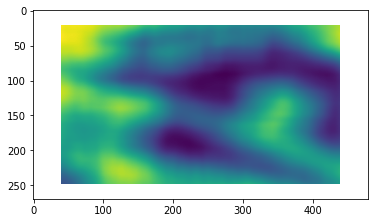

  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

SHAPES (62, 40, 3) (270, 480, 3) (312, 181, 79, 43)
XYWH 312 181 79 43
SHAPES AFTER EXPAND (1, 62, 40, 3) (1, 270, 480, 3)
W, H 62 40
1/1 [==============================] - 0s 422ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


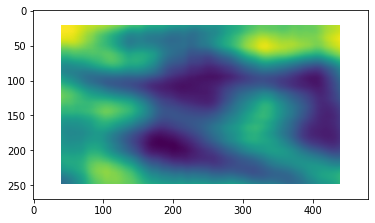

  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:49

SHAPES (62, 40, 3) (270, 480, 3) (55, 106, 73, 47)
XYWH 55 106 73 47
SHAPES AFTER EXPAND (1, 62, 40, 3) (1, 270, 480, 3)
W, H 62 40
1/1 [==============================] - 0s 430ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


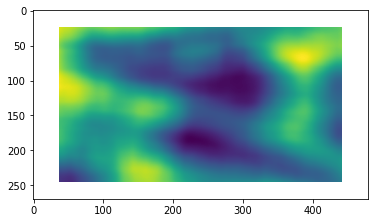

  4% (4 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:02:33

SHAPES (62, 40, 3) (270, 480, 3) (101, 125, 73, 47)
XYWH 101 125 73 47
SHAPES AFTER EXPAND (1, 62, 40, 3) (1, 270, 480, 3)
W, H 62 40
1/1 [==============================] - 0s 439ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


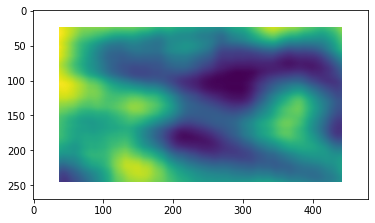

  5% (5 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:02:40

SHAPES (48, 32, 3) (270, 480, 3) (772, 117, 79, 58)
XYWH 772 117 79 58
SHAPES AFTER EXPAND (1, 48, 32, 3) (1, 270, 480, 3)
W, H 48 32
1/1 [==============================] - 1s 582ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


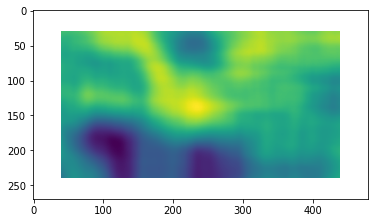

  6% (6 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:03:23

SHAPES (112, 69, 3) (270, 480, 3) (1004, 164, 47, 68)
XYWH 1004 164 47 68
SHAPES AFTER EXPAND (1, 112, 69, 3) (1, 270, 480, 3)
W, H 112 69
1/1 [==============================] - 0s 334ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


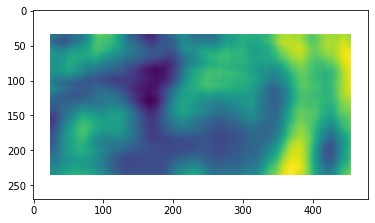

  7% (7 of 100) |#                       | Elapsed Time: 0:00:10 ETA:   0:02:37

SHAPES (59, 64, 3) (270, 480, 3) (616, 225, 93, 58)
XYWH 616 225 93 58
SHAPES AFTER EXPAND (1, 59, 64, 3) (1, 270, 480, 3)
W, H 59 64
1/1 [==============================] - 1s 605ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


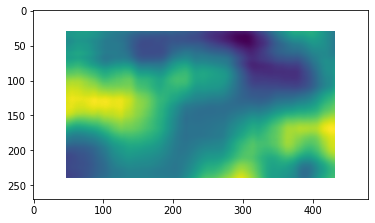

  8% (8 of 100) |#                       | Elapsed Time: 0:00:12 ETA:   0:03:16

SHAPES (137, 69, 3) (270, 480, 3) (813, 317, 58, 101)
XYWH 813 317 58 101
SHAPES AFTER EXPAND (1, 137, 69, 3) (1, 270, 480, 3)
W, H 137 69
1/1 [==============================] - 0s 336ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


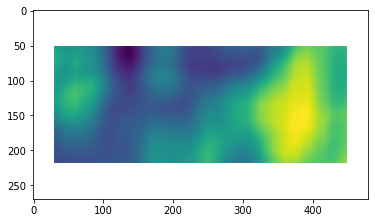

  9% (9 of 100) |##                      | Elapsed Time: 0:00:14 ETA:   0:03:10

SHAPES (61, 49, 3) (270, 480, 3) (987, 73, 41, 60)
XYWH 987 73 41 60
SHAPES AFTER EXPAND (1, 61, 49, 3) (1, 270, 480, 3)
W, H 61 49
1/1 [==============================] - 1s 554ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


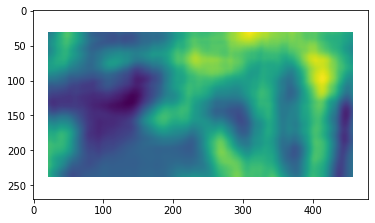

 10% (10 of 100) |##                     | Elapsed Time: 0:00:15 ETA:   0:02:31

SHAPES (136, 69, 3) (270, 480, 3) (1158, 492, 72, 137)
XYWH 1158 492 72 137
SHAPES AFTER EXPAND (1, 136, 69, 3) (1, 270, 480, 3)
W, H 136 69
1/1 [==============================] - 0s 40ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


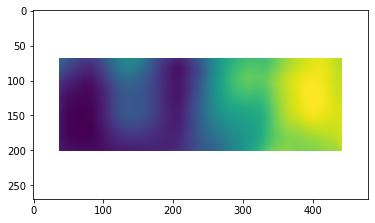

 11% (11 of 100) |##                     | Elapsed Time: 0:00:18 ETA:   0:04:55

SHAPES (32, 42, 3) (270, 480, 3) (586, 381, 75, 58)
XYWH 586 381 75 58
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 270, 480, 3)
W, H 32 42
1/1 [==============================] - 0s 370ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


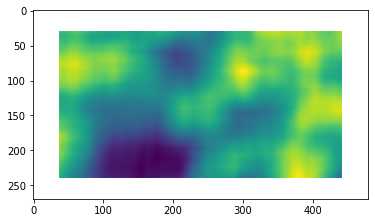

 12% (12 of 100) |##                     | Elapsed Time: 0:00:20 ETA:   0:03:36

SHAPES (63, 48, 3) (270, 480, 3) (100, 348, 66, 79)
XYWH 100 348 66 79
SHAPES AFTER EXPAND (1, 63, 48, 3) (1, 270, 480, 3)
W, H 63 48
1/1 [==============================] - 0s 476ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


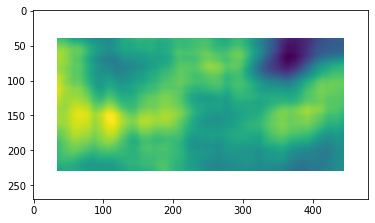

 13% (13 of 100) |##                     | Elapsed Time: 0:00:22 ETA:   0:02:34

SHAPES (50, 72, 3) (270, 480, 3) (510, 198, 73, 50)
XYWH 510 198 73 50
SHAPES AFTER EXPAND (1, 50, 72, 3) (1, 270, 480, 3)
W, H 50 72
1/1 [==============================] - 1s 526ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


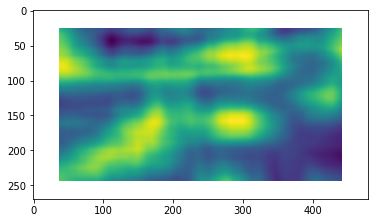

 14% (14 of 100) |###                    | Elapsed Time: 0:00:24 ETA:   0:02:31

SHAPES (43, 32, 3) (270, 480, 3) (153, 649, 61, 63)
XYWH 153 649 61 63
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 270, 480, 3)
W, H 43 32
1/1 [==============================] - 0s 280ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


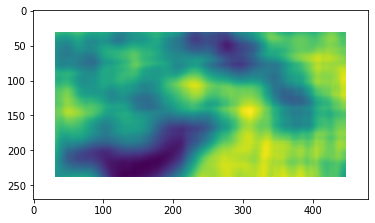

 15% (15 of 100) |###                    | Elapsed Time: 0:00:25 ETA:   0:02:06

SHAPES (32, 42, 3) (270, 480, 3) (533, 334, 75, 48)
XYWH 533 334 75 48
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 270, 480, 3)
W, H 32 42
1/1 [==============================] - 0s 271ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


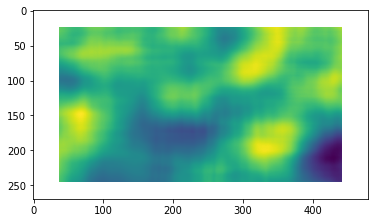

 16% (16 of 100) |###                    | Elapsed Time: 0:00:26 ETA:   0:01:55

SHAPES (56, 83, 3) (270, 480, 3) (881, 236, 68, 58)
XYWH 881 236 68 58
SHAPES AFTER EXPAND (1, 56, 83, 3) (1, 270, 480, 3)
W, H 56 83
1/1 [==============================] - 0s 324ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


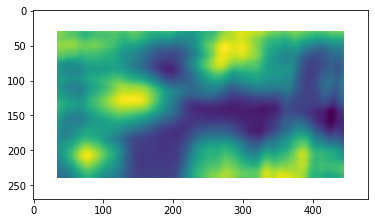

 17% (17 of 100) |###                    | Elapsed Time: 0:00:28 ETA:   0:01:56

SHAPES (70, 104, 3) (270, 480, 3) (14, 388, 103, 68)
XYWH 14 388 103 68
SHAPES AFTER EXPAND (1, 70, 104, 3) (1, 270, 480, 3)
W, H 70 104
1/1 [==============================] - 0s 68ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


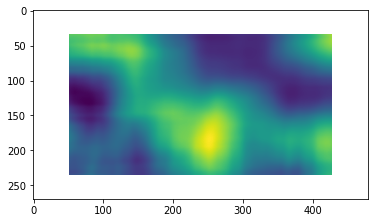

 18% (18 of 100) |####                   | Elapsed Time: 0:00:30 ETA:   0:02:59

SHAPES (65, 57, 3) (270, 480, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 270, 480, 3)
W, H 65 57
1/1 [==============================] - 1s 641ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


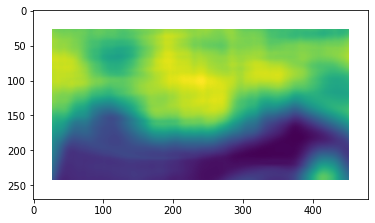

 19% (19 of 100) |####                   | Elapsed Time: 0:00:32 ETA:   0:02:29

SHAPES (103, 97, 3) (270, 480, 3) (912, 284, 65, 79)
XYWH 912 284 65 79
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 270, 480, 3)
W, H 103 97
1/1 [==============================] - 0s 43ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


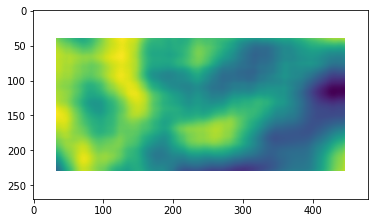

 20% (20 of 100) |####                   | Elapsed Time: 0:00:33 ETA:   0:02:00

SHAPES (43, 32, 3) (270, 480, 3) (184, 623, 53, 61)
XYWH 184 623 53 61
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 270, 480, 3)
W, H 43 32
1/1 [==============================] - 0s 364ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


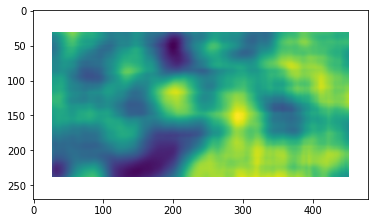

 21% (21 of 100) |####                   | Elapsed Time: 0:00:34 ETA:   0:01:50

SHAPES (33, 41, 3) (270, 480, 3) (632, 204, 74, 49)
XYWH 632 204 74 49
SHAPES AFTER EXPAND (1, 33, 41, 3) (1, 270, 480, 3)
W, H 33 41
1/1 [==============================] - 0s 286ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


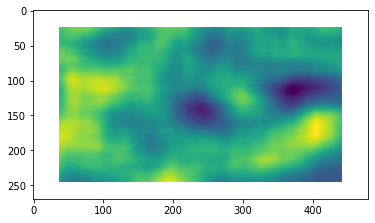

 22% (22 of 100) |#####                  | Elapsed Time: 0:00:36 ETA:   0:01:41

SHAPES (50, 97, 3) (270, 480, 3) (493, 415, 93, 56)
XYWH 493 415 93 56
SHAPES AFTER EXPAND (1, 50, 97, 3) (1, 270, 480, 3)
W, H 50 97
1/1 [==============================] - 0s 38ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


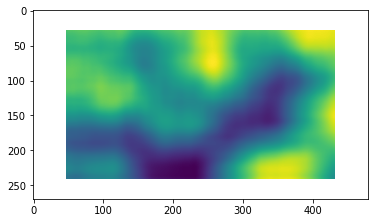

 23% (23 of 100) |#####                  | Elapsed Time: 0:00:37 ETA:   0:01:50

SHAPES (63, 48, 3) (270, 480, 3) (31, 377, 81, 97)
XYWH 31 377 81 97
SHAPES AFTER EXPAND (1, 63, 48, 3) (1, 270, 480, 3)
W, H 63 48
1/1 [==============================] - 1s 539ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


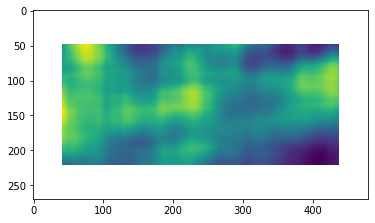

 24% (24 of 100) |#####                  | Elapsed Time: 0:00:40 ETA:   0:03:54

SHAPES (32, 47, 3) (270, 480, 3) (310, 557, 59, 35)
XYWH 310 557 59 35
SHAPES AFTER EXPAND (1, 32, 47, 3) (1, 270, 480, 3)
W, H 32 47
1/1 [==============================] - 0s 382ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


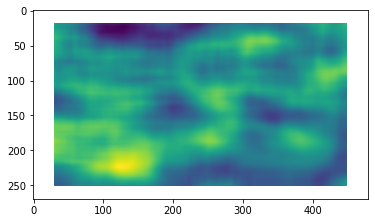

 25% (25 of 100) |#####                  | Elapsed Time: 0:00:41 ETA:   0:02:33

SHAPES (58, 100, 3) (270, 480, 3) (852, 476, 100, 61)
XYWH 852 476 100 61
SHAPES AFTER EXPAND (1, 58, 100, 3) (1, 270, 480, 3)
W, H 58 100
1/1 [==============================] - 0s 42ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


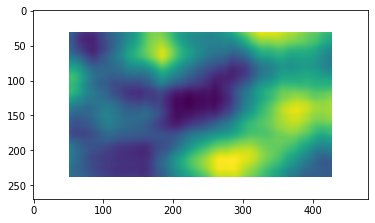

 26% (26 of 100) |#####                  | Elapsed Time: 0:00:43 ETA:   0:01:46

SHAPES (63, 48, 3) (270, 480, 3) (118, 336, 65, 79)
XYWH 118 336 65 79
SHAPES AFTER EXPAND (1, 63, 48, 3) (1, 270, 480, 3)
W, H 63 48
1/1 [==============================] - 1s 551ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


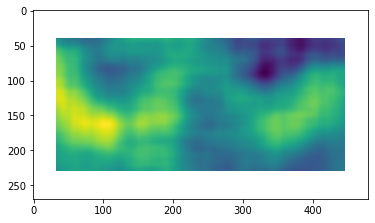

 27% (27 of 100) |######                 | Elapsed Time: 0:00:45 ETA:   0:02:29

SHAPES (103, 97, 3) (270, 480, 3) (855, 294, 55, 81)
XYWH 855 294 55 81
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 270, 480, 3)
W, H 103 97
1/1 [==============================] - 0s 42ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


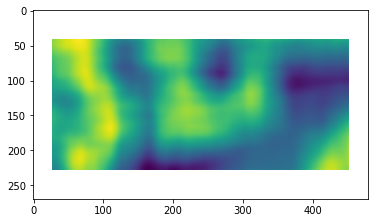

 28% (28 of 100) |######                 | Elapsed Time: 0:00:47 ETA:   0:02:01

SHAPES (32, 42, 3) (270, 480, 3) (663, 440, 87, 58)
XYWH 663 440 87 58
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 270, 480, 3)
W, H 32 42
1/1 [==============================] - 0s 354ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


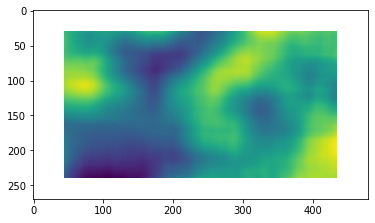

 28% (29 of 100) |######                 | Elapsed Time: 0:00:48 ETA:   0:01:52

SHAPES (136, 69, 3) (270, 480, 3) (956, 447, 65, 130)
XYWH 956 447 65 130
SHAPES AFTER EXPAND (1, 136, 69, 3) (1, 270, 480, 3)
W, H 136 69
1/1 [==============================] - 0s 41ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


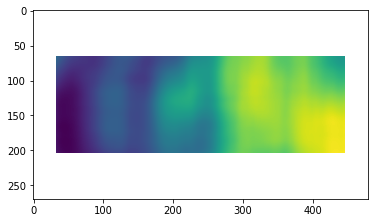

 30% (30 of 100) |######                 | Elapsed Time: 0:00:51 ETA:   0:03:10

SHAPES (50, 72, 3) (270, 480, 3) (864, 213, 74, 50)
XYWH 864 213 74 50
SHAPES AFTER EXPAND (1, 50, 72, 3) (1, 270, 480, 3)
W, H 50 72
1/1 [==============================] - 1s 619ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


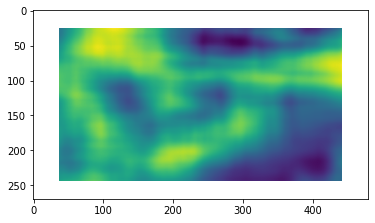

 31% (31 of 100) |#######                | Elapsed Time: 0:00:53 ETA:   0:02:31

SHAPES (64, 84, 3) (270, 480, 3) (436, 630, 97, 79)
XYWH 436 630 97 79
SHAPES AFTER EXPAND (1, 64, 84, 3) (1, 270, 480, 3)
W, H 64 84
1/1 [==============================] - 0s 42ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


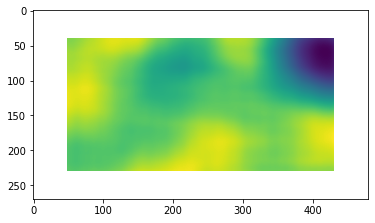

 32% (32 of 100) |#######                | Elapsed Time: 0:00:55 ETA:   0:02:47

SHAPES (32, 42, 3) (270, 480, 3) (560, 358, 75, 53)
XYWH 560 358 75 53
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 270, 480, 3)
W, H 32 42
1/1 [==============================] - 0s 366ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


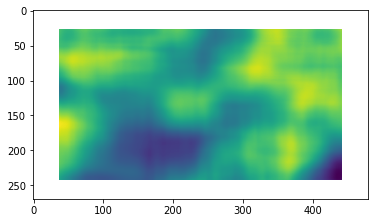

 33% (33 of 100) |#######                | Elapsed Time: 0:00:57 ETA:   0:02:12

SHAPES (118, 84, 3) (270, 480, 3) (839, 296, 64, 94)
XYWH 839 296 64 94
SHAPES AFTER EXPAND (1, 118, 84, 3) (1, 270, 480, 3)
W, H 118 84
1/1 [==============================] - 0s 179ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


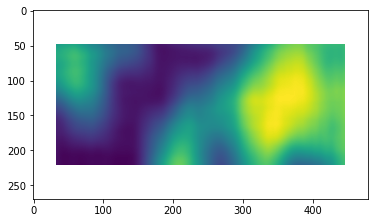

 34% (34 of 100) |#######                | Elapsed Time: 0:00:59 ETA:   0:01:54

SHAPES (122, 72, 3) (270, 480, 3) (509, 304, 50, 89)
XYWH 509 304 50 89
SHAPES AFTER EXPAND (1, 122, 72, 3) (1, 270, 480, 3)
W, H 122 72
1/1 [==============================] - 0s 205ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


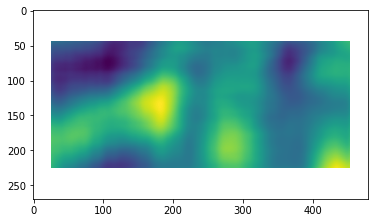

 35% (35 of 100) |########               | Elapsed Time: 0:01:00 ETA:   0:01:52

SHAPES (103, 97, 3) (270, 480, 3) (775, 295, 55, 81)
XYWH 775 295 55 81
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 270, 480, 3)
W, H 103 97
1/1 [==============================] - 0s 45ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


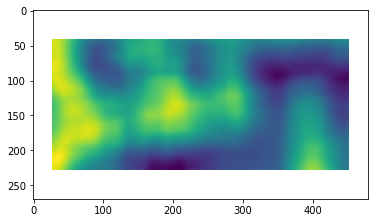

 36% (36 of 100) |########               | Elapsed Time: 0:01:02 ETA:   0:01:30

SHAPES (43, 32, 3) (270, 480, 3) (199, 612, 49, 59)
XYWH 199 612 49 59
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 270, 480, 3)
W, H 43 32
1/1 [==============================] - 0s 370ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


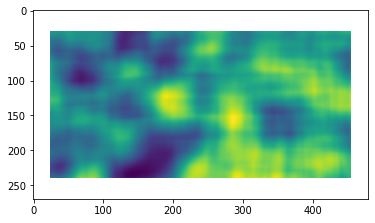

 37% (37 of 100) |########               | Elapsed Time: 0:01:03 ETA:   0:01:20

SHAPES (65, 57, 3) (270, 480, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 270, 480, 3)
W, H 65 57
1/1 [==============================] - 1s 555ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


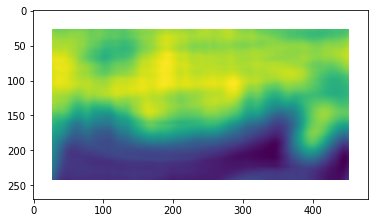

 38% (38 of 100) |########               | Elapsed Time: 0:01:04 ETA:   0:01:25

SHAPES (64, 84, 3) (270, 480, 3) (471, 583, 87, 56)
XYWH 471 583 87 56
SHAPES AFTER EXPAND (1, 64, 84, 3) (1, 270, 480, 3)
W, H 64 84
1/1 [==============================] - 0s 45ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


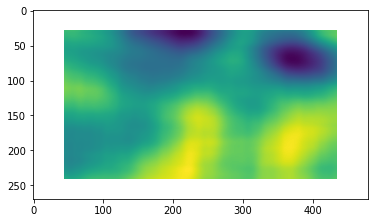

 39% (39 of 100) |########               | Elapsed Time: 0:01:06 ETA:   0:02:13

SHAPES (32, 42, 3) (270, 480, 3) (624, 409, 80, 59)
XYWH 624 409 80 59
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 270, 480, 3)
W, H 32 42
1/1 [==============================] - 0s 381ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


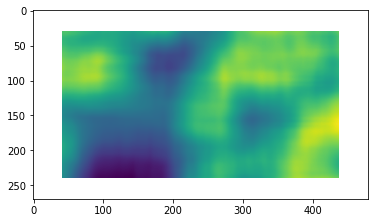

 40% (40 of 100) |#########              | Elapsed Time: 0:01:08 ETA:   0:02:00

SHAPES (103, 97, 3) (270, 480, 3) (509, 297, 47, 90)
XYWH 509 297 47 90
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 270, 480, 3)
W, H 103 97
1/1 [==============================] - 0s 49ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


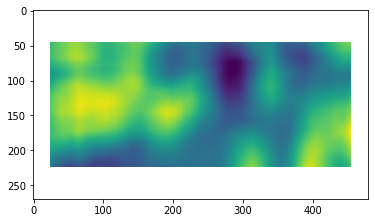

 41% (41 of 100) |#########              | Elapsed Time: 0:01:10 ETA:   0:01:36

SHAPES (137, 69, 3) (270, 480, 3) (800, 306, 57, 74)
XYWH 800 306 57 74
SHAPES AFTER EXPAND (1, 137, 69, 3) (1, 270, 480, 3)
W, H 137 69
1/1 [==============================] - 0s 74ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


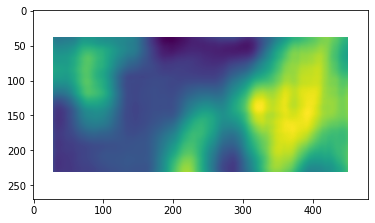

 42% (42 of 100) |#########              | Elapsed Time: 0:01:11 ETA:   0:01:14

SHAPES (58, 100, 3) (270, 480, 3) (1032, 476, 96, 61)
XYWH 1032 476 96 61
SHAPES AFTER EXPAND (1, 58, 100, 3) (1, 270, 480, 3)
W, H 58 100
1/1 [==============================] - 0s 71ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


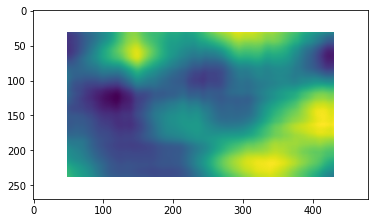

 43% (43 of 100) |#########              | Elapsed Time: 0:01:13 ETA:   0:01:27

SHAPES (103, 97, 3) (270, 480, 3) (516, 268, 47, 90)
XYWH 516 268 47 90
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 270, 480, 3)
W, H 103 97
1/1 [==============================] - 0s 77ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


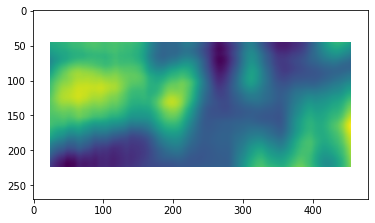

 44% (44 of 100) |##########             | Elapsed Time: 0:01:14 ETA:   0:01:25

SHAPES (66, 42, 3) (270, 480, 3) (330, 21, 41, 68)
XYWH 330 21 41 68
SHAPES AFTER EXPAND (1, 66, 42, 3) (1, 270, 480, 3)
W, H 66 42
1/1 [==============================] - 1s 649ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


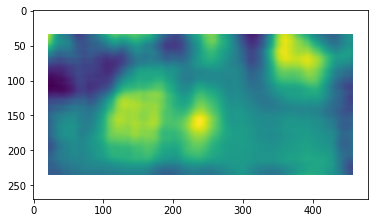

 45% (45 of 100) |##########             | Elapsed Time: 0:01:16 ETA:   0:01:15

SHAPES (32, 42, 3) (270, 480, 3) (512, 311, 73, 45)
XYWH 512 311 73 45
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 270, 480, 3)
W, H 32 42
1/1 [==============================] - 0s 269ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


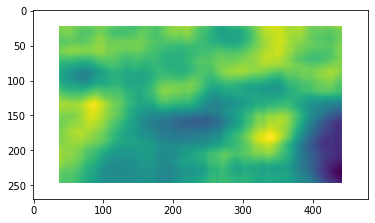

 46% (46 of 100) |##########             | Elapsed Time: 0:01:17 ETA:   0:01:13

SHAPES (59, 64, 3) (270, 480, 3) (562, 229, 92, 58)
XYWH 562 229 92 58
SHAPES AFTER EXPAND (1, 59, 64, 3) (1, 270, 480, 3)
W, H 59 64
1/1 [==============================] - 1s 533ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


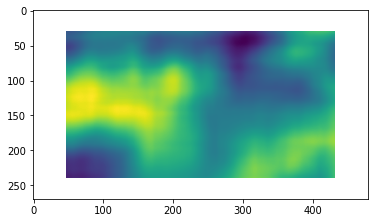

 47% (47 of 100) |##########             | Elapsed Time: 0:01:19 ETA:   0:01:50

SHAPES (65, 57, 3) (270, 480, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 270, 480, 3)
W, H 65 57
1/1 [==============================] - 1s 565ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


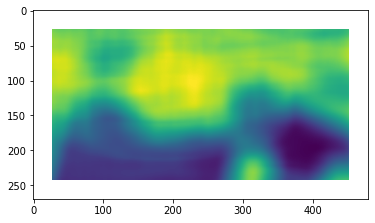

 48% (48 of 100) |###########            | Elapsed Time: 0:01:20 ETA:   0:01:31

SHAPES (118, 84, 3) (270, 480, 3) (847, 296, 63, 94)
XYWH 847 296 63 94
SHAPES AFTER EXPAND (1, 118, 84, 3) (1, 270, 480, 3)
W, H 118 84
1/1 [==============================] - 0s 48ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


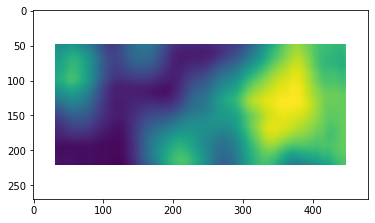

 49% (49 of 100) |###########            | Elapsed Time: 0:01:23 ETA:   0:01:53

SHAPES (32, 42, 3) (270, 480, 3) (496, 290, 68, 45)
XYWH 496 290 68 45
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 270, 480, 3)
W, H 32 42
1/1 [==============================] - 0s 361ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


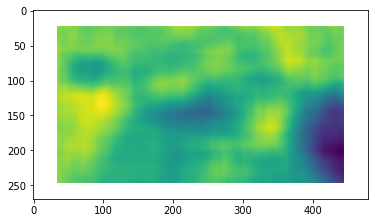

 50% (50 of 100) |###########            | Elapsed Time: 0:01:24 ETA:   0:01:32

SHAPES (43, 32, 3) (270, 480, 3) (136, 673, 64, 47)
XYWH 136 673 64 47
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 270, 480, 3)
W, H 43 32
1/1 [==============================] - 0s 284ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


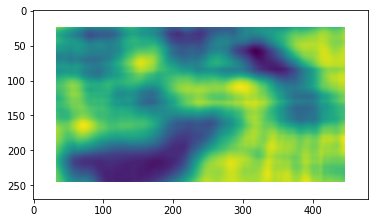

 51% (51 of 100) |###########            | Elapsed Time: 0:01:25 ETA:   0:01:05

SHAPES (128, 78, 3) (270, 480, 3) (898, 270, 42, 85)
XYWH 898 270 42 85
SHAPES AFTER EXPAND (1, 128, 78, 3) (1, 270, 480, 3)
W, H 128 78
1/1 [==============================] - 0s 376ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


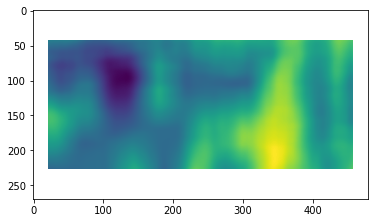

 52% (52 of 100) |###########            | Elapsed Time: 0:01:27 ETA:   0:01:04

SHAPES (64, 84, 3) (270, 480, 3) (456, 550, 87, 61)
XYWH 456 550 87 61
SHAPES AFTER EXPAND (1, 64, 84, 3) (1, 270, 480, 3)
W, H 64 84
1/1 [==============================] - 0s 52ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


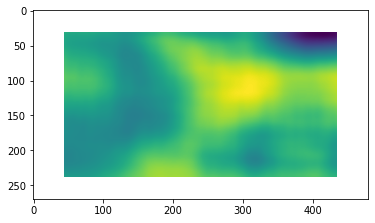

 53% (53 of 100) |############           | Elapsed Time: 0:01:28 ETA:   0:01:12

SHAPES (64, 84, 3) (270, 480, 3) (441, 585, 97, 67)
XYWH 441 585 97 67
SHAPES AFTER EXPAND (1, 64, 84, 3) (1, 270, 480, 3)
W, H 64 84
1/1 [==============================] - 0s 71ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


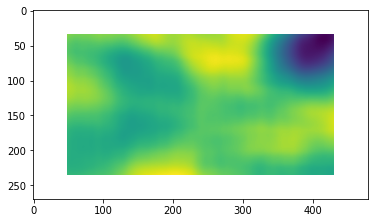

 54% (54 of 100) |############           | Elapsed Time: 0:01:30 ETA:   0:01:33

SHAPES (136, 69, 3) (270, 480, 3) (961, 458, 66, 122)
XYWH 961 458 66 122
SHAPES AFTER EXPAND (1, 136, 69, 3) (1, 270, 480, 3)
W, H 136 69
1/1 [==============================] - 0s 73ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


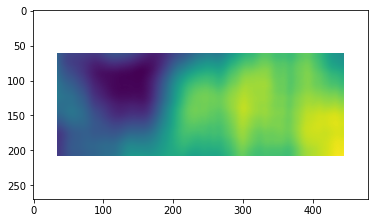

 55% (55 of 100) |############           | Elapsed Time: 0:01:33 ETA:   0:01:59

SHAPES (52, 25, 3) (270, 480, 3) (736, 9, 21, 37)
XYWH 736 9 21 37
SHAPES AFTER EXPAND (1, 52, 25, 3) (1, 270, 480, 3)
W, H 52 25
1/1 [==============================] - 0s 440ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


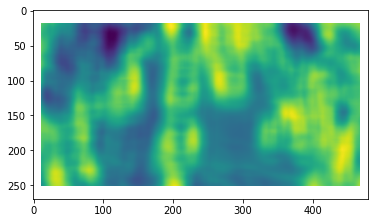

 56% (56 of 100) |############           | Elapsed Time: 0:01:34 ETA:   0:01:16

SHAPES (61, 49, 3) (270, 480, 3) (983, 123, 35, 59)
XYWH 983 123 35 59
SHAPES AFTER EXPAND (1, 61, 49, 3) (1, 270, 480, 3)
W, H 61 49
1/1 [==============================] - 0s 488ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


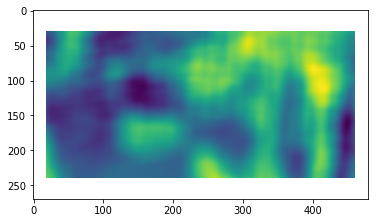

 56% (57 of 100) |#############          | Elapsed Time: 0:01:35 ETA:   0:01:06

SHAPES (43, 32, 3) (270, 480, 3) (167, 637, 58, 62)
XYWH 167 637 58 62
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 270, 480, 3)
W, H 43 32
1/1 [==============================] - 0s 278ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


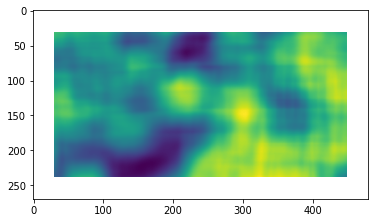

 57% (58 of 100) |#############          | Elapsed Time: 0:01:36 ETA:   0:00:51

SHAPES (50, 72, 3) (270, 480, 3) (457, 199, 74, 50)
XYWH 457 199 74 50
SHAPES AFTER EXPAND (1, 50, 72, 3) (1, 270, 480, 3)
W, H 50 72
1/1 [==============================] - 1s 532ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


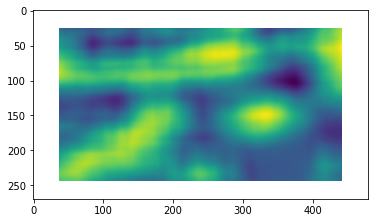

 59% (59 of 100) |#############          | Elapsed Time: 0:01:38 ETA:   0:01:00

SHAPES (101, 65, 3) (270, 480, 3) (306, 270, 68, 53)
XYWH 306 270 68 53
SHAPES AFTER EXPAND (1, 101, 65, 3) (1, 270, 480, 3)
W, H 101 65
1/1 [==============================] - 0s 172ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


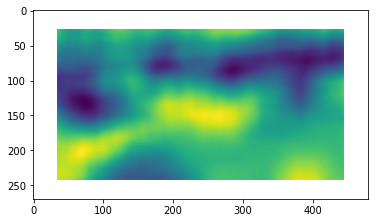

 60% (60 of 100) |#############          | Elapsed Time: 0:01:39 ETA:   0:00:56

SHAPES (43, 32, 3) (270, 480, 3) (228, 587, 42, 56)
XYWH 228 587 42 56
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 270, 480, 3)
W, H 43 32
1/1 [==============================] - 0s 281ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


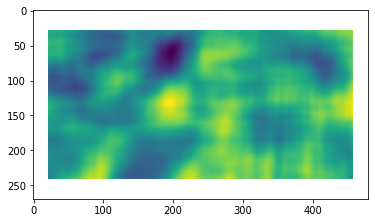

 61% (61 of 100) |##############         | Elapsed Time: 0:01:40 ETA:   0:00:43

SHAPES (65, 57, 3) (270, 480, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 270, 480, 3)
W, H 65 57
1/1 [==============================] - 1s 557ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


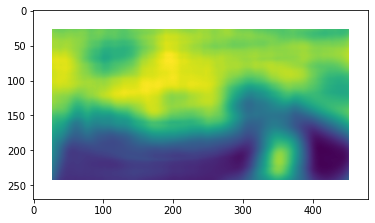

 62% (62 of 100) |##############         | Elapsed Time: 0:01:42 ETA:   0:00:46

SHAPES (65, 57, 3) (270, 480, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 270, 480, 3)
W, H 65 57
1/1 [==============================] - 1s 553ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


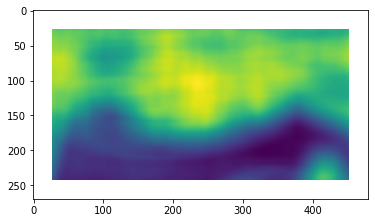

 63% (63 of 100) |##############         | Elapsed Time: 0:01:43 ETA:   0:00:52

SHAPES (45, 124, 3) (270, 480, 3) (837, 233, 148, 61)
XYWH 837 233 148 61
SHAPES AFTER EXPAND (1, 45, 124, 3) (1, 270, 480, 3)
W, H 45 124
1/1 [==============================] - 0s 227ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


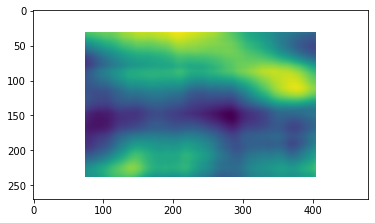

 64% (64 of 100) |##############         | Elapsed Time: 0:01:46 ETA:   0:01:54

SHAPES (72, 138, 3) (270, 480, 3) (772, 471, 171, 58)
XYWH 772 471 171 58
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 270, 480, 3)
W, H 72 138
1/1 [==============================] - 0s 450ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


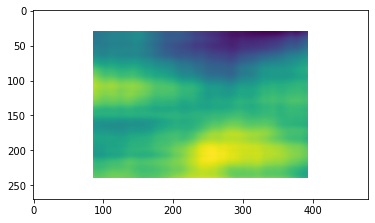

 65% (65 of 100) |##############         | Elapsed Time: 0:01:50 ETA:   0:02:12

SHAPES (115, 86, 3) (270, 480, 3) (447, 410, 84, 118)
XYWH 447 410 84 118
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 270, 480, 3)
W, H 115 86
1/1 [==============================] - 0s 274ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


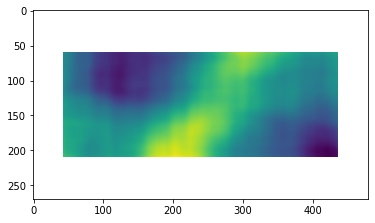

 66% (66 of 100) |###############        | Elapsed Time: 0:01:54 ETA:   0:02:02

SHAPES (115, 86, 3) (270, 480, 3) (179, 149, 132, 75)
XYWH 179 149 132 75
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 270, 480, 3)
W, H 115 86
1/1 [==============================] - 0s 72ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


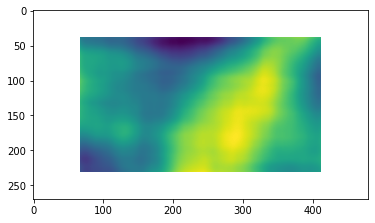

 67% (67 of 100) |###############        | Elapsed Time: 0:01:57 ETA:   0:01:57

SHAPES (115, 86, 3) (270, 480, 3) (374, 223, 122, 81)
XYWH 374 223 122 81
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 270, 480, 3)
W, H 115 86
1/1 [==============================] - 0s 77ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


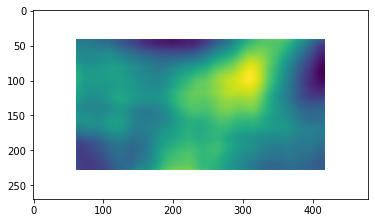

 68% (68 of 100) |###############        | Elapsed Time: 0:02:01 ETA:   0:01:50

SHAPES (103, 58, 3) (270, 480, 3) (612, 315, 65, 114)
XYWH 612 315 65 114
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 270, 480, 3)
W, H 103 58
1/1 [==============================] - 0s 262ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


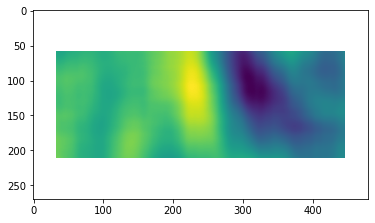

 69% (69 of 100) |###############        | Elapsed Time: 0:02:03 ETA:   0:01:20

SHAPES (62, 159, 3) (270, 480, 3) (260, 252, 160, 62)
XYWH 260 252 160 62
SHAPES AFTER EXPAND (1, 62, 159, 3) (1, 270, 480, 3)
W, H 62 159
1/1 [==============================] - 0s 462ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


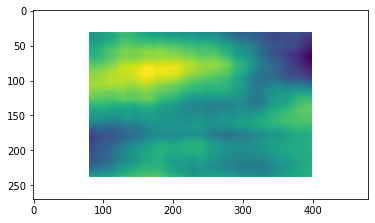

 70% (70 of 100) |################       | Elapsed Time: 0:02:08 ETA:   0:02:24

SHAPES (62, 159, 3) (270, 480, 3) (173, 248, 164, 60)
XYWH 173 248 164 60
SHAPES AFTER EXPAND (1, 62, 159, 3) (1, 270, 480, 3)
W, H 62 159
1/1 [==============================] - 0s 90ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


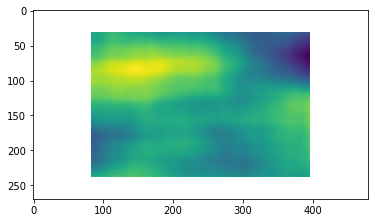

 71% (71 of 100) |################       | Elapsed Time: 0:02:11 ETA:   0:01:38

SHAPES (115, 86, 3) (270, 480, 3) (401, 477, 83, 119)
XYWH 401 477 83 119
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 270, 480, 3)
W, H 115 86
1/1 [==============================] - 0s 73ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


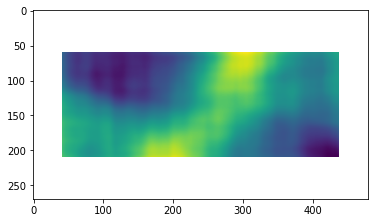

 72% (72 of 100) |################       | Elapsed Time: 0:02:15 ETA:   0:01:34

SHAPES (60, 165, 3) (270, 480, 3) (120, 282, 178, 55)
XYWH 120 282 178 55
SHAPES AFTER EXPAND (1, 60, 165, 3) (1, 270, 480, 3)
W, H 60 165
1/1 [==============================] - 0s 453ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


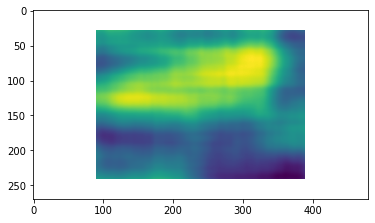

 73% (73 of 100) |################       | Elapsed Time: 0:02:19 ETA:   0:01:41

SHAPES (120, 83, 3) (270, 480, 3) (464, 353, 106, 94)
XYWH 464 353 106 94
SHAPES AFTER EXPAND (1, 120, 83, 3) (1, 270, 480, 3)
W, H 120 83
1/1 [==============================] - 0s 256ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


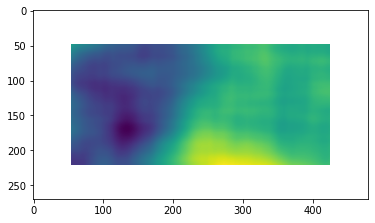

 74% (74 of 100) |#################      | Elapsed Time: 0:02:22 ETA:   0:01:33

SHAPES (120, 82, 3) (270, 480, 3) (623, 205, 84, 117)
XYWH 623 205 84 117
SHAPES AFTER EXPAND (1, 120, 82, 3) (1, 270, 480, 3)
W, H 120 82
1/1 [==============================] - 0s 145ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


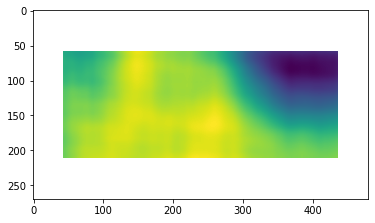

 75% (75 of 100) |#################      | Elapsed Time: 0:02:26 ETA:   0:01:26

SHAPES (62, 159, 3) (270, 480, 3) (87, 241, 171, 58)
XYWH 87 241 171 58
SHAPES AFTER EXPAND (1, 62, 159, 3) (1, 270, 480, 3)
W, H 62 159
1/1 [==============================] - 0s 76ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


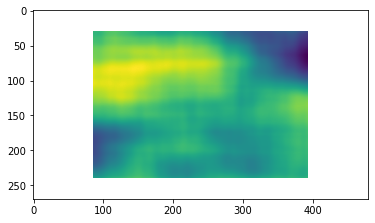

 76% (76 of 100) |#################      | Elapsed Time: 0:02:29 ETA:   0:01:24

SHAPES (56, 175, 3) (270, 480, 3) (486, 405, 169, 59)
XYWH 486 405 169 59
SHAPES AFTER EXPAND (1, 56, 175, 3) (1, 270, 480, 3)
W, H 56 175
1/1 [==============================] - 0s 449ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


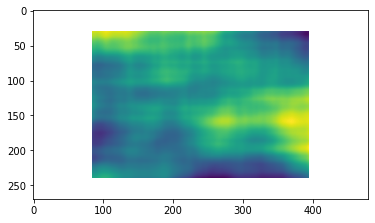

 77% (77 of 100) |#################      | Elapsed Time: 0:02:33 ETA:   0:01:28

SHAPES (83, 79, 3) (270, 480, 3) (303, 84, 79, 83)
XYWH 303 84 79 83
SHAPES AFTER EXPAND (1, 83, 79, 3) (1, 270, 480, 3)
W, H 83 79
1/1 [==============================] - 0s 261ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


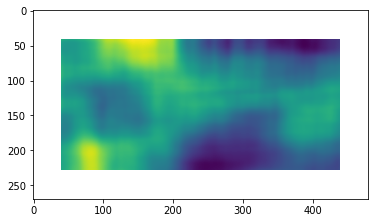

 78% (78 of 100) |#################      | Elapsed Time: 0:02:35 ETA:   0:00:49

SHAPES (60, 165, 3) (270, 480, 3) (175, 282, 176, 56)
XYWH 175 282 176 56
SHAPES AFTER EXPAND (1, 60, 165, 3) (1, 270, 480, 3)
W, H 60 165
1/1 [==============================] - 0s 77ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


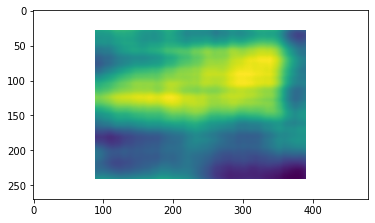

 79% (79 of 100) |##################     | Elapsed Time: 0:02:39 ETA:   0:01:11

SHAPES (72, 138, 3) (270, 480, 3) (575, 460, 165, 60)
XYWH 575 460 165 60
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 270, 480, 3)
W, H 72 138
1/1 [==============================] - 0s 75ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


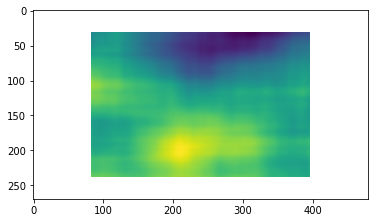

 80% (80 of 100) |##################     | Elapsed Time: 0:02:42 ETA:   0:01:08

SHAPES (72, 138, 3) (270, 480, 3) (488, 456, 167, 59)
XYWH 488 456 167 59
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 270, 480, 3)
W, H 72 138
1/1 [==============================] - 0s 67ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


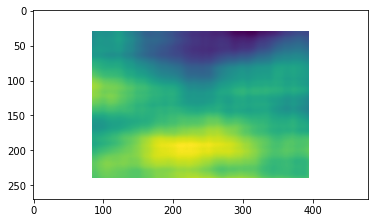

 81% (81 of 100) |##################     | Elapsed Time: 0:02:46 ETA:   0:01:09

SHAPES (120, 82, 3) (270, 480, 3) (655, 263, 78, 127)
XYWH 655 263 78 127
SHAPES AFTER EXPAND (1, 120, 82, 3) (1, 270, 480, 3)
W, H 120 82
1/1 [==============================] - 0s 76ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


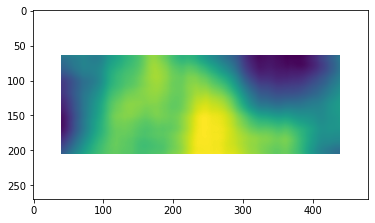

 82% (82 of 100) |##################     | Elapsed Time: 0:02:49 ETA:   0:01:01

SHAPES (62, 159, 3) (270, 480, 3) (210, 250, 162, 61)
XYWH 210 250 162 61
SHAPES AFTER EXPAND (1, 62, 159, 3) (1, 270, 480, 3)
W, H 62 159
1/1 [==============================] - 0s 74ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


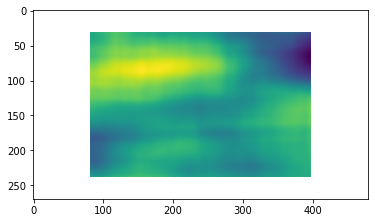

 83% (83 of 100) |###################    | Elapsed Time: 0:02:53 ETA:   0:00:58

SHAPES (103, 58, 3) (270, 480, 3) (609, 311, 65, 114)
XYWH 609 311 65 114
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 270, 480, 3)
W, H 103 58
1/1 [==============================] - 0s 72ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


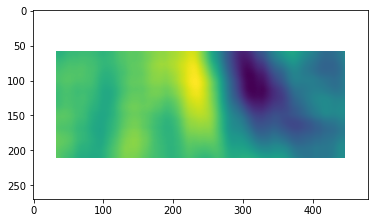

 84% (84 of 100) |###################    | Elapsed Time: 0:02:55 ETA:   0:00:38

SHAPES (26, 56, 3) (270, 480, 3) (601, 184, 25, 27)
XYWH 601 184 25 27
SHAPES AFTER EXPAND (1, 26, 56, 3) (1, 270, 480, 3)
W, H 26 56
1/1 [==============================] - 0s 463ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


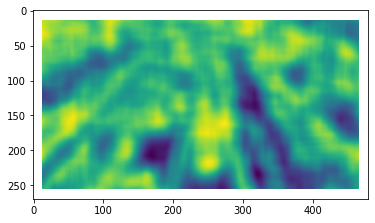

 85% (85 of 100) |###################    | Elapsed Time: 0:02:56 ETA:   0:00:24

SHAPES (120, 82, 3) (270, 480, 3) (605, 295, 70, 142)
XYWH 605 295 70 142
SHAPES AFTER EXPAND (1, 120, 82, 3) (1, 270, 480, 3)
W, H 120 82
1/1 [==============================] - 0s 45ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


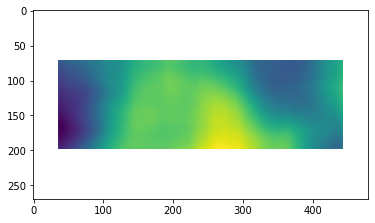

 86% (86 of 100) |###################    | Elapsed Time: 0:02:59 ETA:   0:00:49

SHAPES (88, 113, 3) (270, 480, 3) (241, 173, 136, 73)
XYWH 241 173 136 73
SHAPES AFTER EXPAND (1, 88, 113, 3) (1, 270, 480, 3)
W, H 88 113
1/1 [==============================] - 0s 245ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


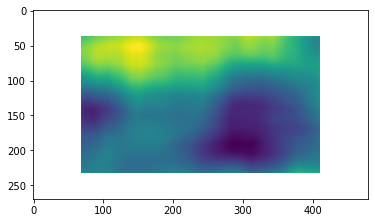

 87% (87 of 100) |####################   | Elapsed Time: 0:03:03 ETA:   0:00:47

SHAPES (72, 138, 3) (270, 480, 3) (628, 464, 170, 58)
XYWH 628 464 170 58
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 270, 480, 3)
W, H 72 138
1/1 [==============================] - 0s 73ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


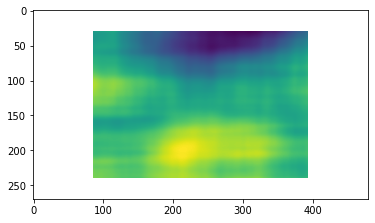

 88% (88 of 100) |####################   | Elapsed Time: 0:03:07 ETA:   0:00:43

SHAPES (62, 158, 3) (270, 480, 3) (908, 408, 158, 63)
XYWH 908 408 158 63
SHAPES AFTER EXPAND (1, 62, 158, 3) (1, 270, 480, 3)
W, H 62 158
1/1 [==============================] - 0s 253ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


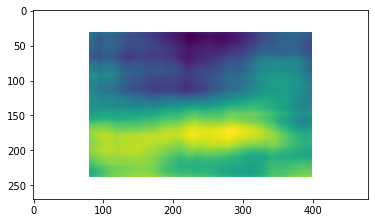

 89% (89 of 100) |####################   | Elapsed Time: 0:03:11 ETA:   0:00:49

SHAPES (103, 58, 3) (270, 480, 3) (605, 308, 69, 114)
XYWH 605 308 69 114
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 270, 480, 3)
W, H 103 58
1/1 [==============================] - 0s 75ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


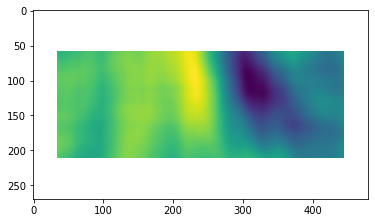

 90% (90 of 100) |####################   | Elapsed Time: 0:03:14 ETA:   0:00:25

SHAPES (83, 79, 3) (270, 480, 3) (291, 83, 78, 83)
XYWH 291 83 78 83
SHAPES AFTER EXPAND (1, 83, 79, 3) (1, 270, 480, 3)
W, H 83 79
1/1 [==============================] - 0s 73ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


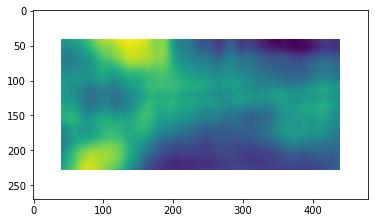

 91% (91 of 100) |####################   | Elapsed Time: 0:03:16 ETA:   0:00:18

SHAPES (62, 158, 3) (270, 480, 3) (978, 419, 164, 60)
XYWH 978 419 164 60
SHAPES AFTER EXPAND (1, 62, 158, 3) (1, 270, 480, 3)
W, H 62 158
1/1 [==============================] - 0s 76ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


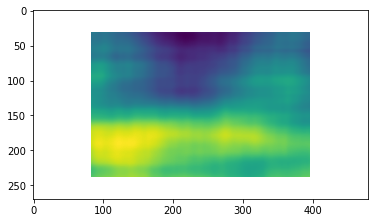

 92% (92 of 100) |#####################  | Elapsed Time: 0:03:19 ETA:   0:00:27

SHAPES (115, 86, 3) (270, 480, 3) (38, 106, 137, 72)
XYWH 38 106 137 72
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 270, 480, 3)
W, H 115 86
1/1 [==============================] - 0s 76ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


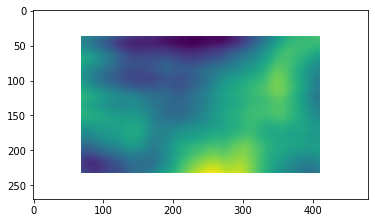

 93% (93 of 100) |#####################  | Elapsed Time: 0:03:23 ETA:   0:00:24

SHAPES (116, 85, 3) (270, 480, 3) (213, 150, 131, 75)
XYWH 213 150 131 75
SHAPES AFTER EXPAND (1, 116, 85, 3) (1, 270, 480, 3)
W, H 116 85
1/1 [==============================] - 0s 221ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


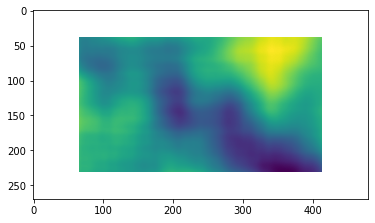

 94% (94 of 100) |#####################  | Elapsed Time: 0:03:26 ETA:   0:00:21

SHAPES (88, 113, 3) (270, 480, 3) (324, 189, 141, 70)
XYWH 324 189 141 70
SHAPES AFTER EXPAND (1, 88, 113, 3) (1, 270, 480, 3)
W, H 88 113
1/1 [==============================] - 0s 74ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


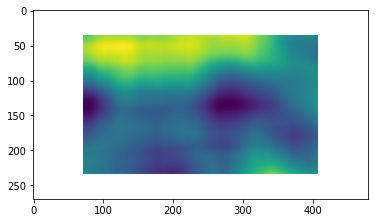

 95% (95 of 100) |#####################  | Elapsed Time: 0:03:30 ETA:   0:00:17

SHAPES (72, 138, 3) (270, 480, 3) (442, 452, 168, 59)
XYWH 442 452 168 59
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 270, 480, 3)
W, H 72 138
1/1 [==============================] - 0s 73ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


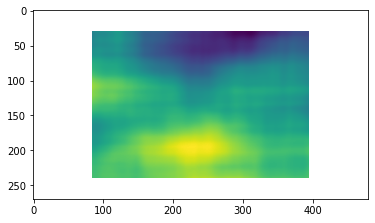

 96% (96 of 100) |###################### | Elapsed Time: 0:03:33 ETA:   0:00:13

SHAPES (96, 81, 3) (270, 480, 3) (454, 134, 71, 104)
XYWH 454 134 71 104
SHAPES AFTER EXPAND (1, 96, 81, 3) (1, 270, 480, 3)
W, H 96 81
1/1 [==============================] - 0s 254ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


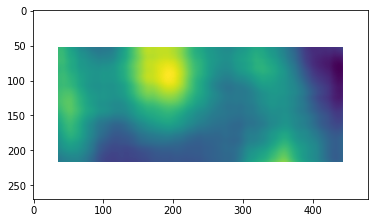

 97% (97 of 100) |###################### | Elapsed Time: 0:03:36 ETA:   0:00:07

SHAPES (96, 81, 3) (270, 480, 3) (86, 196, 90, 110)
XYWH 86 196 90 110
SHAPES AFTER EXPAND (1, 96, 81, 3) (1, 270, 480, 3)
W, H 96 81
1/1 [==============================] - 0s 73ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


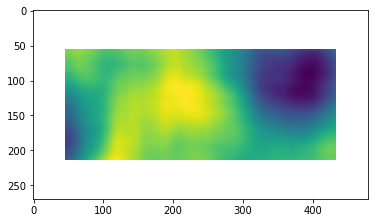

 98% (98 of 100) |###################### | Elapsed Time: 0:03:39 ETA:   0:00:06

SHAPES (103, 58, 3) (270, 480, 3) (591, 318, 74, 89)
XYWH 591 318 74 89
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 270, 480, 3)
W, H 103 58
1/1 [==============================] - 0s 78ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


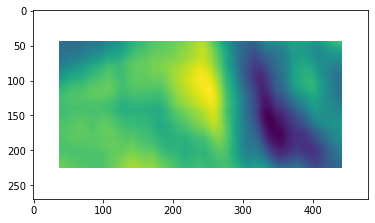

 99% (99 of 100) |###################### | Elapsed Time: 0:03:41 ETA:   0:00:02

SHAPES (103, 58, 3) (270, 480, 3) (614, 313, 66, 114)
XYWH 614 313 66 114
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 270, 480, 3)
W, H 103 58
1/1 [==============================] - 0s 72ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


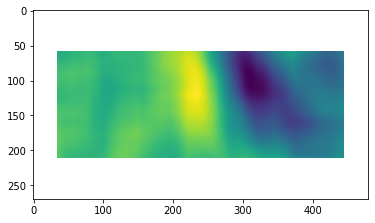

100% (100 of 100) |######################| Elapsed Time: 0:03:44 ETA:  00:00:00

SHAPES (103, 58, 3) (270, 480, 3) (596, 312, 82, 103)
XYWH 596 312 82 103
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 270, 480, 3)
W, H 103 58
1/1 [==============================] - 0s 74ms/step
SALAM
SHAPE AFTER RESIZE (270, 480)
SCORE SHAPE (270, 480)


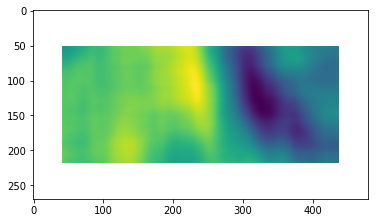

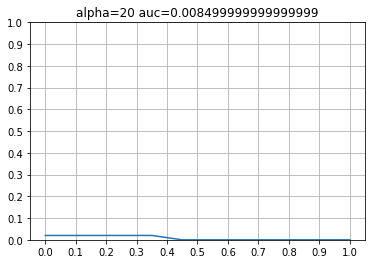

In [ ]:
for k in [20]:
    score_list, gt_list, gray_list = model_eval( featex, alpha=k, backup=featex2)
    iou_score = all_sample_iou( score_list, gt_list )
    plot_success_curve( iou_score, title='alpha={} '.format(k) )